In [87]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm
import time



0.1063 seconds to run with 10 samples


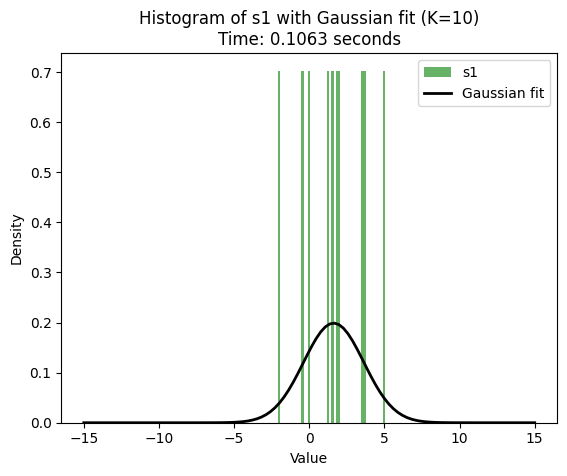

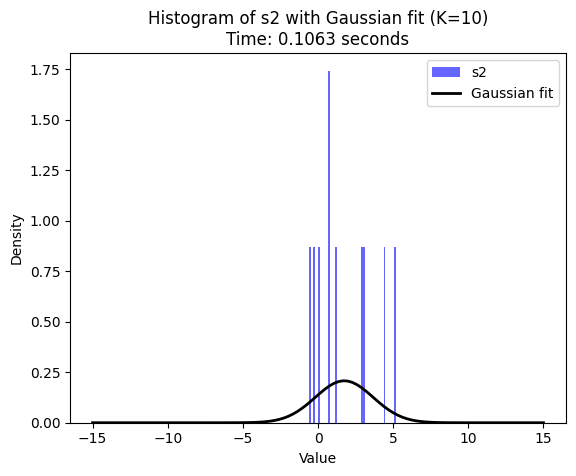

0.0449 seconds to run with 100 samples


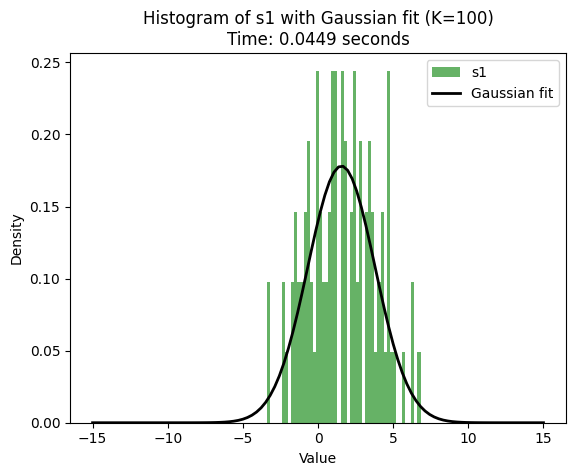

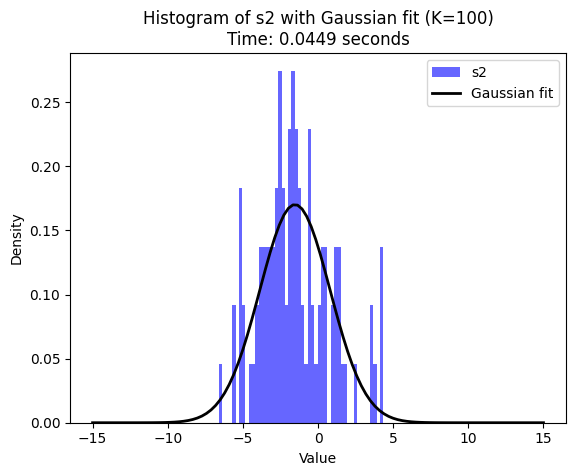

0.6386 seconds to run with 1000 samples


/home/markus2000/miniconda3/envs/apml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


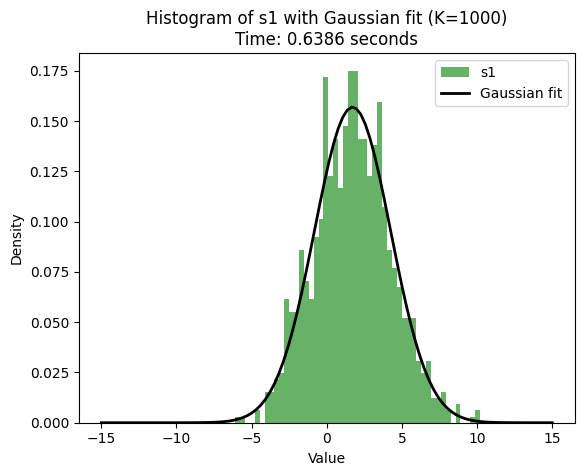

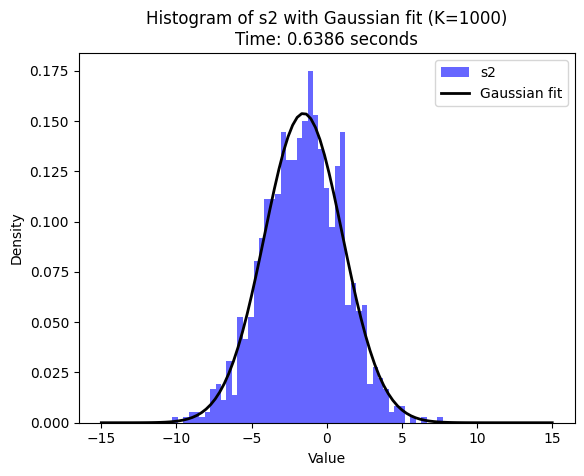

2.8684 seconds to run with 10000 samples


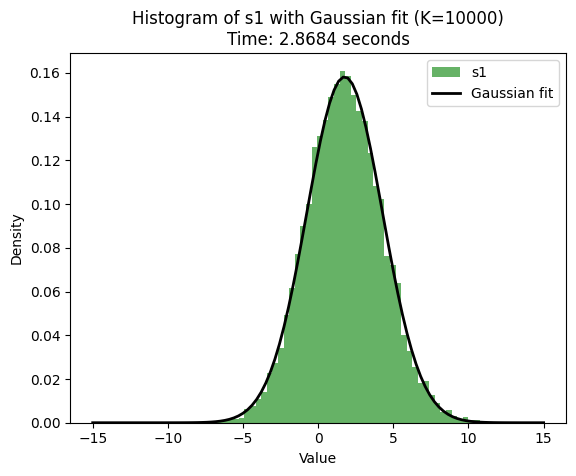

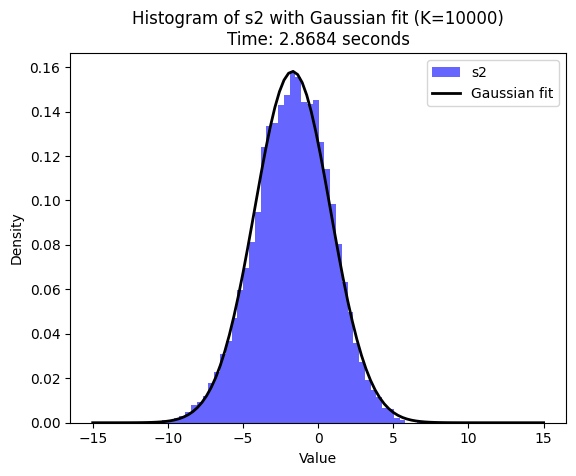

In [88]:
"""
Task 4

"""

def gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])

    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)

    myclip_a = 0
    myclip_b = 1000
    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2

def plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed):
    # Parameters for plotting
    x_s1 = np.linspace(mu1 - 5 * sigma1, mu1 + 5 * sigma1, 100)
    x_s2 = np.linspace(mu2 - 5 * sigma2, mu2 + 5 * sigma2, 100)

    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    S1 = norm.pdf(x_s1, mu_s1, std_s1)

    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)
    S2 = norm.pdf(x_s2, mu_s2, std_s2)

    # Plot s1 histogram and Gaussian fit
    plt.hist(s1, bins=50, density=True, alpha=0.6, color='g', label="s1")
    plt.plot(x_s1, S1, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s1 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Plot s2 histogram and Gaussian fit
    plt.hist(s2, bins=50, density=True, alpha=0.6, color='b', label="s2")
    plt.plot(x_s2, S2, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s2 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()




# Initial parameters
sigma1, sigma2, sigma3 = 3, 3, 1
mu1, mu2 = 0, 0

# Values of K to test
Ks = [10, 100, 1000, 10000]

for K in Ks:
    time_start = time.perf_counter()
    s1, s2, _, _, _, _   = gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K)
    time_elapsed = time.perf_counter() - time_start
    print(f"{time_elapsed:.4f} seconds to run with {K} samples")
    plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed)

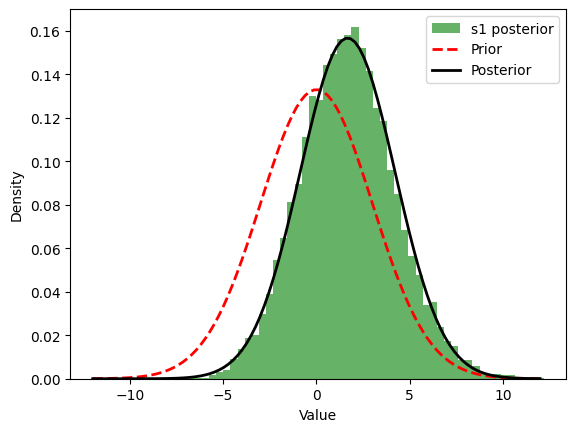

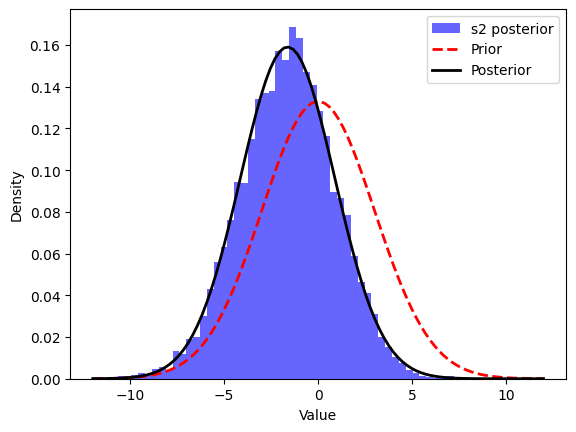

In [89]:
# Gibbs sampling for K=5000
s1, s2, _, _, _, _   = gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K)
# Plotting posteriors and priors
def plot_posterior_vs_prior(s, prior_mu, prior_sigma, label, color):
    # Posterior parameters
    mu_post = np.mean(s)
    sigma_post = np.std(s)

    # Prior distribution
    x = np.linspace(prior_mu - 4 * prior_sigma, prior_mu + 4 * prior_sigma, 100)
    prior = norm.pdf(x, prior_mu, prior_sigma)

    # Posterior distribution
    posterior = norm.pdf(x, mu_post, sigma_post)

    # Plot
    plt.hist(s, bins=50, density=True, alpha=0.6, color=color, label=f"{label} posterior")
    plt.plot(x, prior, 'r--', linewidth=2, label="Prior")
    plt.plot(x, posterior, 'k-', linewidth=2, label="Posterior")
    # plt.title(f"Posterior vs Prior of {label} (K={K})")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot posterior vs prior for s1 and s2
plot_posterior_vs_prior(s1, mu1, sigma1, "s1", 'g')
plot_posterior_vs_prior(s2, mu2, sigma2, "s2", 'b')

In [90]:
"""
Task 5

"""


def gibbs_sampling_T5(mu1, sigma1, mu2, sigma2, sigma3 = np.sqrt(v3)):
    """
    Wrapper function for gibbs_sampling to use a fixed number of samples (5000).

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.

    Returns:
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    K = 1000
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K)
    return (mu_s1, std_s1, mu_s2, std_s2)



def update_team_skills(data):
    """
    Update team skills based on match outcomes.

    Parameters:
    data: DataFrame containing match data.

    Returns:
    team_list: Dictionary with updated team skills.
    df: DataFrame with sorted team skills and ranks.
    """
    teams = data['team1'].drop_duplicates()
    team_list = {team: (0, 5) for team in teams}

    for i in range(data.shape[0]):
        score_diff = data.iloc[i]['score1'] - data.iloc[i]['score2']
        if score_diff != 0:
            winner = data.iloc[i]['team1'] if score_diff > 0 else data.iloc[i]['team2']
            loser = data.iloc[i]['team2'] if score_diff > 0 else data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(
                team_list[winner][0], team_list[winner][1],
                team_list[loser][0], team_list[loser][1]
            )
            team_list[winner] = (mu1, sigma1)
            team_list[loser] = (mu2, sigma2)

    df = pd.DataFrame.from_dict(team_list, orient='index', columns=['Skill', 'Standard Deviation'])
    df.sort_values(by='Skill', ascending=False, inplace=True)
    df['Rank'] = range(1, len(df) + 1)

    return team_list, df

# Load data
data_shuffled = pd.read_csv("SerieA.csv").sample(frac=1).reset_index(drop=True)  # Shuffled data
data_unshuffled = pd.read_csv("SerieA.csv")  # Unshuffled data

# Update team skills for shuffled and unshuffled data
team_list_shuffled, df_shuffled = update_team_skills(data_shuffled)
team_list_unshuffled, df_unshuffled = update_team_skills(data_unshuffled)

# Print results
print("Shuffled Data Team List:\n", df_shuffled)
print("\nUnshuffled Data Team List:\n", df_unshuffled)

Shuffled Data Team List:
                Skill  Standard Deviation  Rank
Juventus    4.172563            0.826513     1
Napoli      2.799822            0.917991     2
Roma        2.301267            0.998517     3
Milan       2.193266            1.084394     4
Inter       2.036156            0.896432     5
Torino      1.923472            1.100706     6
Atalanta    1.520248            0.967815     7
Lazio       0.945088            0.769498     8
Sampdoria   0.314076            0.874684     9
Bologna    -0.598981            0.766675    10
Spal       -0.729763            0.854867    11
Sassuolo   -0.826379            0.993348    12
Genoa      -0.902831            0.981633    13
Empoli     -0.920782            0.899762    14
Cagliari   -1.047134            0.937644    15
Udinese    -1.204127            0.843035    16
Parma      -1.415142            0.892653    17
Fiorentina -1.523386            1.092717    18
Frosinone  -2.897492            0.863327    19
Chievo     -4.561309            1.

In [91]:
"""

Task 6

"""

def predict(mu1, sigma1, mu2, sigma2, result_list):
    L = 1000  # number of samples
    sigma3 = 3

    # Generate L samples from normal distributions for both teams
    s1 = np.random.normal(mu1, sigma1, L)
    s2 = np.random.normal(mu2, sigma2, L)
    
    # Calculate the mean difference between samples
    mean_diff = s1 - s2  
    
    t = np.random.normal(loc=mean_diff, scale=sigma3, size=L)  
    
    # Take the mean of the samples
    mean_t = np.mean(t)
    
    # Determine the sign of the mean (1 if positive, -1 if negative)
    y = np.sign(mean_t)
    
    result_list.append(y)
    
    return result_list

def initialize_team_list(data):
    # Get unique team names
    teams = data['team1'].drop_duplicates()
    
    # Initialize team ratings with a mean of 0 and standard deviation of 5
    team_list = {team: (0, 5) for team in teams}
    
    return team_list

def update_team_ratings(data, team_list, result_list):
    # Iterate over each match in the dataset
    for i in range(data.shape[0]):
        score = data.iloc[i]['score1'] - data.iloc[i]['score2']
        
        # Predict the match result based on current team ratings
        predict(team_list[data.iloc[i]['team1']][0], team_list[data.iloc[i]['team1']][1],
                team_list[data.iloc[i]['team2']][0], team_list[data.iloc[i]['team2']][1], result_list)
        
        # Update team ratings based on match result
        if score > 0:
            winner = data.iloc[i]['team1']
            loser = data.iloc[i]['team2']
        elif score < 0:
            winner = data.iloc[i]['team2']
            loser = data.iloc[i]['team1']
        else:
            continue  # Skip draws for rating updates

        mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1])
        
        # Update the ratings for both the winner and loser
        team_list[winner] = [mu1, sigma1]
        team_list[loser] = [mu2, sigma2]
    
    return team_list

def compare_result(prediction, data):
    true_result = list()
    count = 0
    draw = 0
    # Calculate the actual match results
    score = data['score1'] - data['score2']
    for i in range(data.shape[0]):
        if score[i] > 0:
            true_result.append(1)
        elif score[i] < 0:
            true_result.append(-1)
        else:
            true_result.append(0)
            draw += 1
    
    # Convert lists to numpy arrays for element-wise comparison
    true_result = np.array(true_result)
    prediction = np.array(prediction)
    # Compare predictions with actual results
    count_list = (true_result == prediction)
    count = np.sum(count_list)

    total_matches = data.shape[0]
    pred_rate = count / total_matches
    
    # Print the results
    # print("Predict Result:", count_list)
    print("Number of correct predictions:", count)
    print("Prediction rate:", pred_rate)
    
    return count_list

data = pd.read_csv("SerieA.csv") 

# Initialize the team list
team_list = initialize_team_list(data)

# List to store prediction results
result_list = []

# Update team ratings based on match data and generate predictions
team_list = update_team_ratings(data, team_list, result_list)

# Compare the prediction results with actual data
predict_list = compare_result(result_list, data)

Number of correct predictions: 177
Prediction rate: 0.46578947368421053


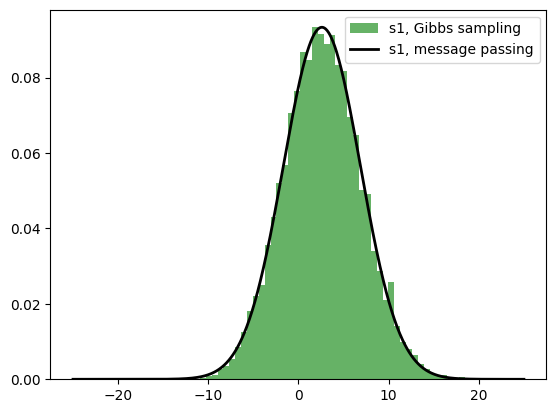

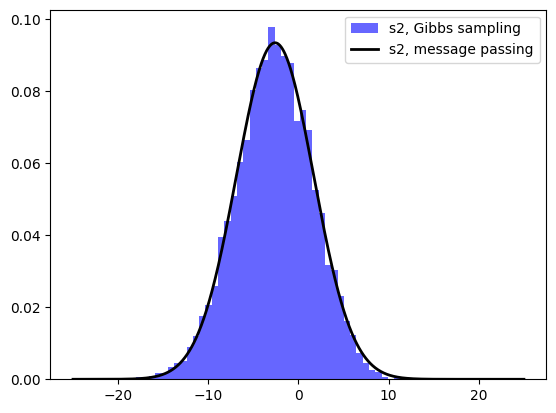

In [92]:
"""

Task 7

"""


def multiplyGauss(m1,s1,m2,s2):
    s = 1/(1/s1+1/s2)
    m = (m1/s1+m2/s2)*s
    return m, s

def divideGauss(m1,s1,m2,s2):
    s = 1/(1/s1-1/s2)
    m = (m1/s1-m2/s2)*s
    return m, s

def truncGauss(my_a, my_b, m1, s1):
    # Calculate the parameters for the truncated normal distribution
    a, b = (my_a - m1) / np.sqrt(s1), (my_b - m1) / np.sqrt(s1)
    # Compute the mean of the truncated normal distribution
    m = truncnorm.mean(a, b, loc=m1, scale=np.sqrt(s1))
    # Compute the variance of the truncated normal distribution
    s = truncnorm.var(a, b, loc=m1, scale=np.sqrt(s1))
    return m, s

# Defining the 5 hyperparameters
# y0 = 1 indicates that player 1 won a game
mu1 = 0
mu2 = 0
v1 = 5**2
v2 = 5**2
v3 = 3**2
y0 = 1



K = 10000
def gibbs_sampling(mu1, sigma1, mu2, sigma2, K, sigma3 = np.sqrt(v3)):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])
    sigma3 = sigma3
    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)

    myclip_a = 0
    myclip_b = 1000
    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2

s1, s2, mu1_Gibbs, sigma1_Gibbs, mu2_Gibbs, sigma2_Gibbs   = gibbs_sampling(mu1, np.sqrt(v1), mu2,  np.sqrt(v2), K)


#Compute mu5 and v5
mu5 = mu1 - mu2
v5 = v1 + v2 + v3

# Do moment matching of the marginal of t
if y0==1:
    a, b = 0, 20000
else:
    a, b = -20000, 0

#Turning the truncated Gaussian into a Gaussian
mu, v = truncGauss(a,b,mu5,v5)

#Compute mu9 and v9
mu9, v9 = divideGauss(mu,v,mu5,v5)

#Compute mu10 and v10
mu10, v10 = mu2 + mu9, v2 + v3 + v9
#Compute mu11 and v11
mu11, v11 = mu1 - mu9, v1 + v3 + v9

# Compute the marginal of s1 and s2
mu_s1, v_s1 = multiplyGauss(mu1,v1,mu10,v10)
mu_s2, v_s2 = multiplyGauss(mu2,v2,mu11,v11)

#--------MAKING THE PLOT------
#Parameters
L = 1000 #number of samples
x = np.linspace(mu1-v1, mu1+v1, 1000)

# #Draw values from the Gaussian distributions
# s1_norm = np.random.normal(mu_s1, np.sqrt(v_s1), L)
# s2_norm = np.random.normal(mu_s2, np.sqrt(v_s2), L)

# mu_s1 = np.mean(s1_norm)
# mu_s2 = np.mean(s2_norm)
# var_s1 = np.var(s1_norm)
# var_s2 = np.var(s2_norm)

#Making pdf:s
s1_pdf = norm.pdf(x, mu_s1, np.sqrt(v_s1))
s2_pdf = norm.pdf(x, mu_s2, np.sqrt(v_s2))

#Make a plot
plt.hist(s1, label="s1, Gibbs sampling", bins =50, density=True, alpha=0.6, color='g')
plt.plot(x, s1_pdf, linewidth=2, label="s1, message passing", color='black')
plt.legend()
plt.show()
plt.hist(s2, label="s2, Gibbs sampling", bins =50, density=True, alpha=0.6, color='b')
plt.plot(x, s2_pdf, linewidth=2, label="s2, message passing", color='black')
plt.legend()
plt.show()

In [103]:
#Task 9 preprocessing 1
game_results = pd.read_excel('chessResults.xlsx')
game_results = game_results[['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','Unnamed: 9',  'Unnamed: 10','Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']]
game_results = game_results.rename(columns={
    'Unnamed: 3': 'Name',
    'Unnamed: 4': 'Rating',
    'Unnamed: 6': 'Round 1',
    'Unnamed: 7': 'Round 2',
    'Unnamed: 8': 'Round 3',
    'Unnamed: 9': 'Round 4',
    'Unnamed: 10': 'Round 5',
    'Unnamed: 11': 'Round 6',
    'Unnamed: 12': 'Round 7',
    'Unnamed: 13': 'Round 8',
    'Unnamed: 14': 'Round 9',
})

game_results = game_results[18:154]
game_results = game_results.drop(columns=['Unnamed: 5'])

game_results = game_results.reset_index(drop=True)


import re


name1 = []
score1 = []
name2 = []
score2 = []
for i in range(1, 10):
    players_processed = []
    for j in range(0, len(game_results)):
        #print(j)
        if game_results.loc[j, 'Name'] not in players_processed and isinstance(game_results.loc[j, f'Round {i}'], str):
            
            if "b1" in game_results.loc[j, f'Round {i}']: 
                name1.append(game_results.loc[j, 'Name'])
                score1.append(1)
                players_processed.append(game_results.loc[j, 'Name'])
                pattern = r'(\d+)b1'
                #print('type', type(game_results.loc[j, f'Round {i}']))
                match = re.findall(pattern, game_results.loc[j, f'Round {i}'])
                #print(match)
                name2.append(game_results.loc[int(match[0])-1, 'Name'])
                score2.append(0)
                players_processed.append(game_results.loc[int(match[0])-1, 'Name'])  

            elif "w1" in game_results.loc[j, f'Round {i}']:    
                name1.append(game_results.loc[j, 'Name'])
                score1.append(1)
                players_processed.append(game_results.loc[j, 'Name'])
                pattern = r'(\d+)w1'
                match = re.findall(pattern, game_results.loc[j, f'Round {i}'])
                #print('match',match)
                name2.append(game_results.loc[int(match[0])-1, 'Name'])
                score2.append(0)
                players_processed.append(game_results.loc[int(match[0])-1, 'Name'])
                

                # Find all matches of the pattern in the string
                
#task 9 preprocessing 3
game_scores = pd.DataFrame({
    'team1': name1,
    'score1': score1,
    'team2': name2,
    'score2': score2
})
pd.set_option('display.max_rows', None)


In [102]:
#task 9
# Update team skills for shuffled and unshuffled data
def update_team_skills_t9(data, sigma_3):
    rate_enumerator = 0
    rate_denominator = 0
    """
    Update team skills based on match outcomes.

    Parameters:
    data: DataFrame containing match data.

    Returns:
    team_list: Dictionary with updated team skills.
    df: DataFrame with sorted team skills and ranks.
    """
    teams = game_results['Name']
    rating = game_results['Rating']
    team_list = {team: (rating[i], 200) for i, team in enumerate(teams)}

    for i in range(data.shape[0]):
        score_diff = data.iloc[i]['score1'] - data.iloc[i]['score2']
        if score_diff != 0:
            winner = data.iloc[i]['team1'] if score_diff > 0 else data.iloc[i]['team2']
            loser = data.iloc[i]['team2'] if score_diff > 0 else data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(
                team_list[winner][0], team_list[winner][1],
                team_list[loser][0], team_list[loser][1], sigma3 = sigma_3
            )
            if team_list[winner][0] > team_list[loser][0]:
                rate_enumerator += 1
            team_list[winner] = (mu1, sigma1)
            team_list[loser] = (mu2, sigma2)
            rate_denominator += 1

    df = pd.DataFrame.from_dict(team_list, orient='index', columns=['Skill', 'Standard Deviation'])
    df.sort_values(by='Skill', ascending=False, inplace=True)
    df['Rank'] = range(1, len(df) + 1)

    return team_list, df, rate_enumerator/rate_denominator
for sigma3 in [100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]:
    team_list_unshuffled, df_unshuffled, rate_bayes = update_team_skills_t9(game_scores, sigma3)
    print(f'sigma 3: {sigma3}, rate bayes: {rate_bayes}')


sigma 3: 100, rate bayes: 0.7154471544715447
sigma 3: 120, rate bayes: 0.7262872628726287
sigma 3: 140, rate bayes: 0.7208672086720868
sigma 3: 160, rate bayes: 0.7127371273712737
sigma 3: 180, rate bayes: 0.7317073170731707
sigma 3: 200, rate bayes: 0.7181571815718157
sigma 3: 220, rate bayes: 0.7208672086720868
sigma 3: 240, rate bayes: 0.7235772357723578
sigma 3: 260, rate bayes: 0.7317073170731707
sigma 3: 280, rate bayes: 0.7262872628726287
sigma 3: 300, rate bayes: 0.7262872628726287


In [101]:
# calculation according to elo formula after tournament
def elo_update(k):
    player_ratings = {name: rating for name, rating in zip(game_results['Name'], game_results['Rating'])}
    rate_enumerator = 0
    rate_denominator = 0

    for game in game_scores.itertuples():
        new_rating_player_1 = 20*(1-1/(10**((player_ratings[game.team2]-player_ratings[game.team1])/400)+1))
        new_rating_player_2 = 20*(0-1/(10**((player_ratings[game.team1]-player_ratings[game.team2])/400)+1))
        if player_ratings[game.team2] < player_ratings[game.team1]:
            rate_enumerator += 1
        player_ratings[game.team1] += new_rating_player_1
        player_ratings[game.team2] += new_rating_player_2
        rate_denominator += 1
    rate_elo = rate_enumerator/rate_denominator
    return rate_elo


k_factors = [5, 10, 20, 40]
for k in k_factors:
    print(f'prediction rate for {k} is {elo_update(k)}')




prediction rate for 5 is 0.7289972899728997
prediction rate for 10 is 0.7289972899728997
prediction rate for 20 is 0.7289972899728997
prediction rate for 40 is 0.7289972899728997


In [45]:
"""

Task 10

"""
alpha = 0.1
data = pd.read_csv("SerieA.csv") 
def gibbs_sampling(mu1, sigma1, mu2, sigma2, K, myclip_a, myclip_b):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])
    sigma3 = 1  

    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)


    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2



def gibbs_sampling_T5(mu1, sigma1, mu2, sigma2, myclip_a, myclip_b):
    """
    Wrapper function for gibbs_sampling to use a fixed number of samples (5000).

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.

    Returns:
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    K = 1000
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, K, myclip_a, myclip_b)
    return (mu_s1, std_s1, mu_s2, std_s2)




def predict(mu1, sigma1, mu2, sigma2, predict_list):
    L = 1000  # number of samples
    sigma3 = 1

    # Generate L samples from normal distributions for both teams
    s1 = np.random.normal(mu1, sigma1, L)
    s2 = np.random.normal(mu2, sigma2, L)
    
    # Calculate the mean difference between samples
    mean_diff = s1 - s2  
    
    t = np.random.normal(loc=mean_diff, scale=sigma3, size=L)  
    
    # Take the mean of the samples
    mean_t = np.mean(t)
    
    # Determine the sign of the mean (1 if positive, -1 if negative)
    y = np.sign(mean_t + alpha)/2 + np.sign(mean_t - alpha)/2
    
    predict_list.append(y)
    
    return predict_list

def initialize_team_list(data):
    # Get unique team names
    teams = data['team1'].drop_duplicates()
    
    # Initialize team ratings with a mean of 0 and standard deviation of 5
    team_list = {team: (0, 1) for team in teams}
    
    return team_list

def update_team_ratings(data, team_list, predict_list):
    # Iterate over each match in the dataset
    for i in range(data.shape[0]):
        score = data.iloc[i]['score1'] - data.iloc[i]['score2']
        
        # Predict the match result based on current team ratings
        predict(team_list[data.iloc[i]['team1']][0], team_list[data.iloc[i]['team1']][1],
                team_list[data.iloc[i]['team2']][0], team_list[data.iloc[i]['team2']][1], predict_list)
        
        # Update team ratings based on match result
        if score > 0:
            winner = data.iloc[i]['team1']
            loser = data.iloc[i]['team2']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],
                                                     myclip_a = alpha, myclip_b = 1000)
        elif score < 0:
            winner = data.iloc[i]['team2']
            loser = data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],
                                                     myclip_a = alpha, myclip_b = 1000)
        else:
            team1 = data.iloc[i]['team1']
            team2 = data.iloc[i]['team2']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[team1][0], team_list[team1][1], 
                                                         team_list[team2][0], team_list[team2][1],
                                                        myclip_a=-alpha, myclip_b=alpha)


        
        # Update the ratings in the team list
        if score != 0:
            team_list[winner] = [mu1, sigma1]
            team_list[loser] = [mu2, sigma2]
        else:  # For draw case, both teams are updated
            team_list[team1] = [mu1, sigma1]
            team_list[team2] = [mu2, sigma2]
    
    return team_list

def compare_result(prediction, data):
    true_result = list()
    count = 0
    draw = 0
    # Calculate the actual match results
    score = data['score1'] - data['score2']
    for i in range(data.shape[0]):
        if score[i] > 0:
            true_result.append(1)
        elif score[i] < 0:
            true_result.append(-1)
        else:
            true_result.append(0)
            draw += 1
    
    # Convert lists to numpy arrays for element-wise comparison
    true_result = np.array(true_result)
    prediction = np.array(prediction)
    # Compare predictions with actual results
    count_list = (true_result == prediction)
    count = np.sum(count_list)

    total_matches = data.shape[0]
    pred_rate = count / total_matches
    pred_rate_discard_zeros = count / (total_matches - draw)
    # Print the results
    print("Predict Result:", count_list)
    print("Number of correct predictions:", count)
    print("Prediction rate:", pred_rate)
    print("Prediction rate if disregarding draws:", pred_rate_discard_zeros)
    return count_list, true_result

data = pd.read_csv("SerieA.csv") 

# Initialize the team list
team_list = initialize_team_list(data)

# List to store prediction results
predict_list = []

# Update team ratings based on match data and generate predictions
team_list = update_team_ratings(data, team_list, predict_list)

# Compare the prediction results with actual data
predict_result, true_result = compare_result(predict_list, data)

Predict Result: [False False False False  True False False False  True  True  True False
  True False False  True False  True False False  True  True False False
 False False False False False False  True False False  True  True False
  True False False  True False False False  True False  True False False
  True False False  True  True  True  True  True  True  True False False
  True  True False  True  True  True  True False  True  True False  True
  True False  True False  True  True  True False False  True False False
  True False False False  True False  True False False False False  True
 False False False  True  True  True False  True  True False False  True
  True  True False False False  True False False False False False  True
 False  True  True False False False False  True  True False  True  True
  True  True  True False False False False  True  True  True False False
  True  True False False False False  True  True False False  True  True
  True  True False False  True Fals

In [40]:
np.array(predict_list)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
       -1.,  0.,  1., -1.,  0., -1.,  0., -1.,  0., -1.,  0., -1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        1., -1.,  0.,  1., -1., -1., -1., -1.,  1., -1., -1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0., -1., -1., -1.,  1.,  1., -1., -1.,  1.,
       -1.,  1.,  1.,  0.,  1.,  0., -1., -1.,  1.,  1., -1., -1.,  1.,
       -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  0., -1., -1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        1.,  0.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  0., -1.,
       -1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  0.,  0.,  0.,
        0., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,
        1.,  0., -1.,  1.,  0.,  0.,  1.,  1., -1.,  1.,  0., -1.,  1.,
       -1.,  1., -1., -1.,  1.,  1.,  0.,  1.,  1., -1., -1.,  1., -1.,
        1., -1.,  1.,  1.,  0., -1., -1.,  1.,  0.,  0., -1.,  1

In [28]:
true_result

array([-1, -1, -1,  1,  0,  1, -1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,
        0,  1, -1, -1,  1,  1,  1,  1,  1,  0, -1, -1,  1, -1,  0,  0,  1,
        1, -1,  0,  1,  0,  1,  1,  1, -1, -1,  1, -1,  1,  0, -1,  1, -1,
        1,  1,  1,  1,  0,  0, -1,  0,  1,  1,  1,  1, -1,  1, -1,  1, -1,
        1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1,  0, -1,  0, -1, -1,
        0,  0,  1,  0,  1, -1,  0,  0, -1,  0,  1,  1,  0, -1,  1,  1,  1,
        0,  1,  1, -1,  0, -1, -1, -1,  0, -1,  0, -1,  1,  1,  1,  0,  0,
       -1,  1,  1,  1,  1,  0,  1,  0,  0,  0,  0,  0, -1,  1,  1,  1,  0,
        0,  0,  0, -1,  1,  1,  0,  0,  0, -1,  0,  1,  0,  0,  1, -1,  0,
        1, -1,  1, -1,  1,  1,  0,  1,  0,  0,  1, -1,  1, -1,  0,  0,  1,
        0,  1, -1,  1, -1,  0,  1,  0,  1,  1,  1,  1, -1, -1,  0,  0, -1,
        1,  1,  1,  1, -1,  0, -1,  0,  0,  0,  1, -1,  1,  1,  1,  0, -1,
       -1, -1,  0,  1, -1, -1,  0,  1,  0,  0,  0,  0, -1,  0, -1, -1,  1,
       -1,  0, -1,  0,  1

In [44]:
team_list

{'Juventus': [0.6130441457382649, 0.27129237909879805],
 'Napoli': [0.42080086794922805, 0.221154140889617],
 'Roma': [0.20439538477310037, 0.18557710494968646],
 'Inter': [0.2518886952541207, 0.2003825289131021],
 'Lazio': [-0.057459007243943365, 0.21592516710938722],
 'Milan': [0.2518458620495287, 0.2207894107123939],
 'Atalanta': [0.312324911722023, 0.20867249185815126],
 'Fiorentina': [-0.4519893045560138, 0.21827665405720123],
 'Sampdoria': [-0.17033932141781144, 0.1698230907425138],
 'Torino': [0.11230693182070885, 0.21010188194929127],
 'Sassuolo': [-0.4058320692282357, 0.20519911579297348],
 'Genoa': [-0.5270736310952021, 0.23065326605809386],
 'Chievo': [-0.9367490275815608, 0.19811906757426115],
 'Udinese': [-0.5499528497252059, 0.20146654390940677],
 'Cagliari': [-0.48862807083081966, 0.1973908672975558],
 'Bologna': [-0.43284759962990926, 0.20565502293714152],
 'Spal': [-0.7119275248713359, 0.17916044172447046],
 'Frosinone': [-0.9592946531493356, 0.199217263074801],
 'Empo

In [70]:
data_2017_2018 = pd.read_csv("SerieA-2017-2018.csv")

def get_prior(rank):
    if rank <= 20:
        return 3 - 0.25 * (rank - 1), 3
    else:
        return -2, 3
    
team_priors = {}
for _, row in data_2017_2018.iterrows():
    team_priors[row['Team']] = get_prior(row['Rank'])

In [71]:
team_priors

{'Juventus': (3.0, 3),
 'Napoli': (2.75, 3),
 'Roma': (2.5, 3),
 'Inter': (2.25, 3),
 'Lazio': (2.0, 3),
 'Milan': (1.75, 3),
 'Atalanta': (1.5, 3),
 'Fiorentina': (1.25, 3),
 'Sampdoria': (1.0, 3),
 'Torino': (0.75, 3),
 'Sassuolo': (0.5, 3),
 'Genoa': (0.25, 3),
 'Chievo': (0.0, 3),
 'Udinese': (-0.25, 3),
 'Cagliari': (-0.5, 3),
 'Bologna': (-0.75, 3),
 'Spal': (-1.0, 3),
 'Crotone': (-1.25, 3),
 'Verona': (-1.5, 3),
 'Benevento': (-1.75, 3)}

In [177]:
"""

Task 10

"""
alpha = 0.15
beta = 0.05

data_2017_2018 = pd.read_csv("SerieA-2017-2018.csv")
data = pd.read_csv("SerieA.csv") 

def gibbs_sampling(mu1, sigma1, mu2, sigma2, K, myclip_a, myclip_b):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])
    sigma3 = 1

    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)


    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2



def gibbs_sampling_T5(mu1, sigma1, mu2, sigma2, myclip_a, myclip_b):
    """
    Wrapper function for gibbs_sampling to use a fixed number of samples (5000).

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.

    Returns:
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    K = 1000
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, K, myclip_a, myclip_b)
    return (mu_s1, std_s1, mu_s2, std_s2)



def predict(mu1, sigma1, mu2, sigma2, predict_list):
    L = 1000  # number of samples
    sigma3 = 1

    # Generate L samples from normal distributions for both teams
    s1 = np.random.normal(mu1, sigma1, L)
    s2 = np.random.normal(mu2, sigma2, L)
    
    # Calculate the mean difference between samples
    mean_diff = s1 - s2  
    
    t = np.random.normal(loc=mean_diff, scale=sigma3, size=L)  
    
    # Take the mean of the samples
    mean_t = np.mean(t)
    
    # Determine the sign of the mean (1 if positive, -1 if negative)
    y = np.sign(mean_t + alpha)/2 + np.sign(mean_t - alpha)/2
    
    predict_list.append(y)
    
    return predict_list




def get_prior(rank):
    if rank <= 20:
        return 2 - 0.25 * (rank - 1), 1

    


def initialize_team_list(data, data_priors):
    # Get unique team names
    teams = data['team1'].drop_duplicates()
    team_list = {}
    for _, row in data_2017_2018.iterrows():
        team_list[row['Team']] = get_prior(row['Rank'])
    new_teams = set(teams) - set(team_list.keys())
    team_list_items = list(team_list.items())[:-3]
    team_list = dict(team_list_items)
    for team in new_teams:
        team_list[team] = (-3, 3)
    
    
    return team_list

def update_team_ratings(data, team_list, predict_list):
    # Iterate over each match in the dataset
    for i in range(data.shape[0]):
        score = data.iloc[i]['score1'] - data.iloc[i]['score2']
        
        # Predict the match result based on current team ratings
        predict(team_list[data.iloc[i]['team1']][0] + beta, team_list[data.iloc[i]['team1']][1],
                team_list[data.iloc[i]['team2']][0], team_list[data.iloc[i]['team2']][1], predict_list)
        
        # Update team ratings based on match result
        if score > 0:
            winner = data.iloc[i]['team1']
            loser = data.iloc[i]['team2']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],
                                                     myclip_a = alpha, myclip_b = 1000)
        elif score < 0:
            winner = data.iloc[i]['team2']
            loser = data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],
                                                     myclip_a = alpha, myclip_b = 1000)
        else:
            team1 = data.iloc[i]['team1']
            team2 = data.iloc[i]['team2']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[team1][0], team_list[team1][1], 
                                                         team_list[team2][0], team_list[team2][1],
                                                        myclip_a=-alpha, myclip_b=alpha)


        
        # Update the ratings in the team list
        if score != 0:
            team_list[winner] = [mu1, sigma1]
            team_list[loser] = [mu2, sigma2]
        else:  # For draw case, both teams are updated
            team_list[team1] = [mu1, sigma1]
            team_list[team2] = [mu2, sigma2]
    
    return team_list

def compare_result(prediction, data):
    true_result = list()
    count = 0
    draw = 0
    # Calculate the actual match results
    score = data['score1'] - data['score2']
    for i in range(data.shape[0]):
        if score[i] > 0:
            true_result.append(1)
        elif score[i] < 0:
            true_result.append(-1)
        else:
            true_result.append(0)
            draw += 1
    
    # Convert lists to numpy arrays for element-wise comparison
    true_result = np.array(true_result)
    prediction = np.array(prediction)
    # Compare predictions with actual results
    count_list = (true_result == prediction)
    count = np.sum(count_list)

    total_matches = data.shape[0]
    pred_rate = count / total_matches
    # Print the results
    print("Predict Result:", count_list)
    print("Number of correct predictions:", count)
    print("Prediction rate:", pred_rate)
    return count_list, true_result


# Initialize the team list
team_list = initialize_team_list(data, data_2017_2018)

# List to store prediction results
predict_list = []

# Update team ratings based on match data and generate predictions
team_list = update_team_ratings(data, team_list, predict_list)

# Compare the prediction results with actual data
predict_result, true_result = compare_result(predict_list, data)

Predict Result: [ True  True  True False False False False  True  True  True  True False
 False False False  True False False False  True  True  True  True False
 False  True False False False  True  True False False  True  True  True
 False False  True  True False  True False  True  True False False False
  True False  True  True  True  True  True False  True  True False False
  True  True False  True  True  True  True False  True  True  True  True
  True  True  True False  True  True  True False False  True False  True
  True False False  True False False  True False False False False  True
 False False False  True  True  True  True  True  True False False  True
  True  True False False False  True False  True False False False  True
 False  True  True False False False False  True  True  True  True  True
  True  True  True False False False False  True  True  True False False
  True  True False  True False False  True  True  True False  True  True
  True  True False False  True Fals

In [173]:
A = np.array(predict_list)
B = true_result
count0 = 0 
count1 = 0
count_1 = 0
for i in range(len(B)):
    if A[i] == 0 and B[i] ==0:
        count0 +=1
    elif A[i] == 1 and B[i] == 1:
        count1 +=1
    elif A[i] == -1 and B[i] == -1:
        count_1 +=1


print(count0, count1, count_1)


14 105 75


In [176]:
draw = 0
win = 0
lose = 0
for i in range(len(B)):
    if B[i] ==0:
        draw +=1
    elif B[i] == 1:
        win +=1
    elif B[i] == -1:
        lose +=1

print(draw, win, lose)
draw/(draw + win + lose)

108 166 106


0.28421052631578947